# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
random.uniform(10, 600)

548.9946882151672

In [12]:
import numpy as np
np.random.normal(10, 2)

9.057518035828513

In [29]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=False, time_on_site=209.27321087194935, mobile=False),
 User(purchased=False, time_on_site=320.635670345549, mobile=True),
 User(purchased=True, time_on_site=656.7701214019546, mobile=True),
 User(purchased=True, time_on_site=666.0821871361638, mobile=True),
 User(purchased=True, time_on_site=482.0722908706248, mobile=True),
 User(purchased=False, time_on_site=531.3259087586263, mobile=True),
 User(purchased=False, time_on_site=361.7156643045132, mobile=True),
 User(purchased=False, time_on_site=794.5265878110738, mobile=True),
 User(purchased=True, time_on_site=320.20659536572896, mobile=True),
 User(purchased=False, time_on_site=630.7545324569822, mobile=False)]

In [30]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,209.273211,False
1,False,320.635670,True
2,True,656.770121,True
3,True,666.082187,True
4,True,482.072291,True


In [31]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,False,209.273211,False,3.487887
1,False,320.635670,True,5.343928
2,True,656.770121,True,10.946169
3,True,666.082187,True,11.101370
4,True,482.072291,True,8.034538


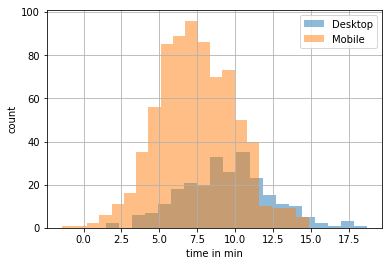

In [32]:
import matplotlib.pyplot as plt
user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5);
plt.xlabel('time in min');
plt.ylabel('count');
plt.legend(['Desktop', 'Mobile']);


In [33]:
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
629,False,-83.949742,True,-1.399162


In [34]:
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min


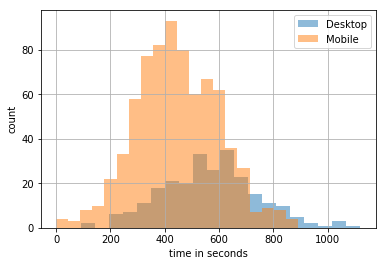

In [38]:
user_data.groupby('mobile').time_on_site.hist(bins=20, alpha=0.5);
plt.xlabel('time in seconds');
plt.ylabel('count');
plt.legend(['Desktop', 'Mobile']);

In [39]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,4.47155546918691,33.389765083758846,42.704910637938724,71.09969284794431,84.27181713763008,85.91170694845738,89.42311663641743,90.34912959557431,101.54157248920308,107.4215638362652,112.67502010319072,114.98401764219341,116.2831860732058,124.8115490370227,125.36220457880609,128.63930985697834,136.78517954156416,146.65956455141384,149.3198149843248,151.35634211283406,155.6626878616903,158.52605733613188,163.6156799946283,165.63560795658066,174.75306136894193,174.96246563936205,185.35143667715806,185.35656665704545,188.1416089505284,190.3911218345682,191.68174781957157,193.084741568614,194.0768575683753,195.57833204999295,196.20644006623553,200.26679237866568,201.12989050385463,201.19402874041742,201.71136106737288,...,795.6965778540437,798.3530318559756,801.2213530856266,802.6826136574721,802.7478621827332,805.9369489477754,807.6078690015823,808.320347181741,808.3506135725227,813.4079198712825,814.0135985241711,822.7861571622882,827.4989813683333,829.808456784787,830.0947181066522,832.3905594606937,838.0181169369719,838.2189925001937,839.1137631856873,841.8282941801415,850.8629553446258,854.9024149399438,856.4302832915575,861.402502059259,862.9755537455761,865.7900993022627,866.014023419458,869.3967908041443,877.862041555555,888.8356609436347,889.4943050221789,889.993592489172,890.3154922025958,928.3280351739807,934.6345077383569,1010.0768576196235,1031.735788389694,1048.8229000151052,1068.8047471788288,1120.385336618616
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
True,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,...,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,0,1


In [40]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(-1.12, 224.077]",33,21
"(224.077, 448.154]",199,204
"(448.154, 672.231]",156,272
"(672.231, 896.308]",31,77
"(896.308, 1120.385]",2,5


In [41]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(-1.12, 224.077]",0.078385,0.036269
"(224.077, 448.154]",0.472684,0.352332
"(448.154, 672.231]",0.370546,0.469775
"(672.231, 896.308]",0.073634,0.132988
"(896.308, 1120.385]",0.004751,0.008636


In [42]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.508,0.392
True,0.492,0.608


In [0]:
time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins

In [53]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['mobile'], user_data['purchased']], normalize='columns')

mobile               False               True           
purchased            False     True      False     True 
time_on_site_min                                        
(-1.419, 2.615]   0.015748  0.000000  0.044218  0.015351
(2.615, 6.63]     0.204724  0.121951  0.462585  0.300439
(6.63, 10.644]    0.566929  0.439024  0.421769  0.565789
(10.644, 14.659]  0.196850  0.390244  0.071429  0.111842
(14.659, 18.673]  0.015748  0.048780  0.000000  0.006579

## Stanford Open Police Project


In [55]:
from google.colab import files
uploaded = files.upload()

Saving tr137st9964_nj_camden_2019_02_25.csv.zip to tr137st9964_nj_camden_2019_02_25.csv.zip


In [56]:
!unzip tr137st9964_nj_camden_2019_02_25.csv.zip

Archive:  tr137st9964_nj_camden_2019_02_25.csv.zip
  inflating: share/data/opp-for-archive/nj_camden_2019_02_25.csv  


In [61]:
!ls

sample_data  share  tr137st9964_nj_camden_2019_02_25.csv.zip


In [63]:
%%time
df = pd.read_csv('./share/data/opp-for-archive/nj_camden_2019_02_25.csv')

CPU times: user 933 ms, sys: 86 ms, total: 1.02 s
Wall time: 1.03 s


<string>:2: DtypeWarning: Columns (9,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.


In [64]:
df.head()

,raw_row_number,date,time,location,lat,lng,subject_age,subject_race,subject_sex,unit,type,disposition,arrest_made,citation_issued,warning_issued,outcome,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state,vehicle_year
0,1,2013-05-01,02:09:00,N 7TH ST & YORK ST CAMDEN NEW JERSEY 08102,39.104028,-84.512616,19.099665,hispanic,male,NaN,vehicular,clear stop,False,False,False,NaN,"BLUE,DARK",MITSUBISHI,LANCER,NaN,2002.0
1,2,2013-05-01,03:51:00,N FRONT ST & YORK ST CAMDEN NEW JERSEY 08102,39.951751,-75.124895,23.242124,white,male,NaN,vehicular,summons,False,True,False,citation,MAROON,HYUNDAI,SANTA FE,NJ,2004.0
2,3,2013-05-01,04:23:00,S 17TH ST & FEDERAL ST CAMDEN NEW JERSEY 08105,39.944575,-75.100156,34.733136,black,female,NaN,vehicular,field contact card,False,False,False,NaN,BLACK,CHEVROLET,SUBURBAN,NJ,2008.0
3,4,2013-05-01,07:57:00,N 5TH ST & YORK ST CAMDEN NEW JERSEY 08102,39.953857,-75.118494,37.468309,hispanic,male,NaN,pedestrian,field contact card,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2013-05-01,07:58:00,N 4TH ST & ERIE ST CAMDEN NEW JERSEY 08102,39.955115,-75.119466,27.272329,white,male,NaN,pedestrian,summons,False,True,False,citation,GRAY,HONDA,ACCORD,NJ,2000.0


In [67]:
df.shape

(206466, 21)

In [66]:
df.isna().sum()

raw_row_number                     0
date                             205
time                             203
location                        2664
lat                             3943
lng                             3943
subject_age                     2363
subject_race                    1943
subject_sex                      151
unit                          118115
type                               0
disposition                       11
arrest_made                        2
citation_issued                    2
warning_issued                     2
outcome                       107779
vehicle_color                  58475
vehicle_make                   58219
vehicle_model                  59977
vehicle_registration_state     52709
vehicle_year                   60395
dtype: int64

In [70]:
df.disposition.value_counts()

field contact card                         101265
summons                                     51847
warning                                     43892
arrest                                       2948
clear stop                                   1331
other report                                 1118
incident report                               982
assigment complete                            755
person advised                                600
community intelligence card                   515
clear break/wash/maintenance/etc              439
person assisted                               145
handled by other unit or agency                95
miscellaneous                                  93
taken to hospital                              76
cancelled                                      56
deficiency not found                           47
x-ref call                                     34
premise checked: found secure                  31
traffic stop                                   28


In [71]:
df.vehicle_make.value_counts(normalize=True)[:10]

CHEVROLET                          0.126438
HONDA                              0.125244
NISSAN                             0.087219
FORD                               0.077890
TOYOTA                             0.068986
DODGE                              0.065917
BUICK                              0.037397
HYUNDAI                            0.033957
CHRYSLER                           0.033856
FORD (ALSO SEE ENGLISH, FRENCH)    0.030483
Name: vehicle_make, dtype: float64

In [72]:
df[df.disposition == 'summons'].shape

(51847, 21)

In [74]:
df[df.disposition == 'summons'].vehicle_make.value_counts(normalize=True)[:10]

CHEVROLET    0.130112
HONDA        0.117861
FORD         0.096843
NISSAN       0.085073
DODGE        0.066898
TOYOTA       0.060672
BUICK        0.042036
CHRYSLER     0.035070
HYUNDAI      0.030186
ACURA        0.025642
Name: vehicle_make, dtype: float64

In [75]:
df.vehicle_color.value_counts()

BLACK                     19604
SILVER                    17546
WHITE                     15177
GRAY                       9377
Black                      9323
RED                        8993
BLUE                       8221
Aluminum/silver            8011
White                      7127
GREEN                      6626
Gray                       5248
GOLD                       4304
Blue                       4006
Red                        3808
TAN                        3096
Green                      2421
BEIGE                      2072
Gold                       1717
MAROON                     1648
BLUE,DARK                  1253
Tan                        1178
Maroon/burgundy             849
GREEN,DARK                  780
BLUE,LIGHT                  753
BROWN                       737
Beige                       719
Brown                       394
Dark Blue                   322
GREEN,LIGHT                 312
PURPLE                      310
                          ...  
YELLOW  

In [76]:
df[df.disposition == 'summons'].vehicle_color.value_counts(normalize=True)

BLACK                     0.148244
SILVER                    0.138827
WHITE                     0.114017
RED                       0.071773
GRAY                      0.071153
BLUE                      0.067554
GREEN                     0.054439
Black                     0.040565
Aluminum/silver           0.036766
GOLD                      0.033567
White                     0.031668
TAN                       0.025010
Gray                      0.023071
Red                       0.017913
Blue                      0.017833
BEIGE                     0.015154
MAROON                    0.012135
Green                     0.011935
BLUE,DARK                 0.008977
Gold                      0.007817
BLUE,LIGHT                0.006937
GREEN,DARK                0.006258
BROWN                     0.006098
Tan                       0.005518
Maroon/burgundy           0.003899
Beige                     0.003239
PURPLE                    0.002579
GREEN,LIGHT               0.002099
Brown               

In [78]:
df = pd.DataFrame({'a': np.arange(1e6), 
                 'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [79]:
%timeit df['c'] = df['a']**2

100 loops, best of 3: 12.8 ms per loop


In [80]:
# lambda is an anonymous function
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

1 loop, best of 3: 315 ms per loop


In [84]:
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
%timeit df['c2'] = df['a'].progress_apply(lambda x: x**2)

my bar!: 100%|██████████| 1000000/1000000 [00:01<00:00, 716572.90it/s]


1 loop, best of 3: 1.4 s per loop


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [13]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/ngriggs/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
print(df.shape)
df.head(5)


(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [14]:
# Oof. Looks like someone made a copy of the df then wrote the copy to a new csv file.

df = df.drop('Unnamed: 0', axis=1)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


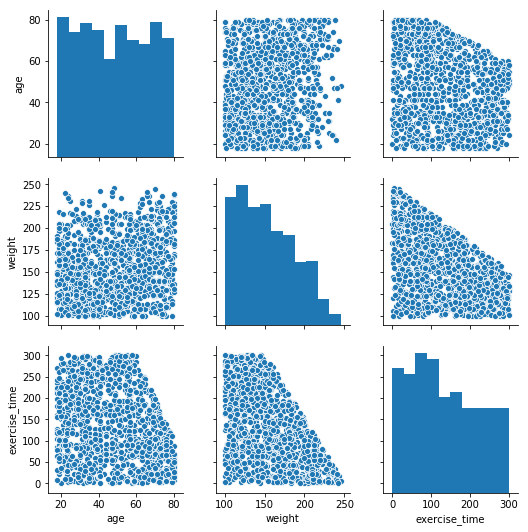

In [15]:
import seaborn as sns
sns.pairplot(df);

From the pairplots, we can see that there doesnt seem to be any relationship between 
weight and age. Let's take a closer look and see if we're right

In [0]:
# Let's bin some of the variables

age_bins = pd.cut(df['age'], 3)



In [68]:
age_bins_list = set(age_bins.to_list())
age_bins_list

{Interval(17.938, 38.667, closed='right'),
 Interval(38.667, 59.333, closed='right'),
 Interval(59.333, 80.0, closed='right')}

In [88]:
age_bins.value_counts()

(17.938, 38.667]    426
(59.333, 80.0]      390
(38.667, 59.333]    384
Name: age, dtype: int64

In [89]:
# Lets make sure our legend is correct
df.groupby(age_bins).exercise_time.mean()

age
(17.938, 38.667]    149.143192
(38.667, 59.333]    160.867188
(59.333, 80.0]       93.807692
Name: exercise_time, dtype: float64

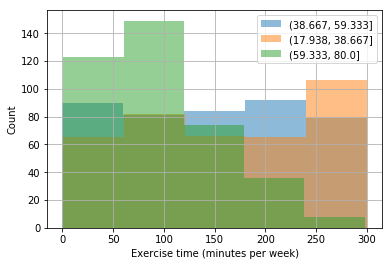

In [78]:
# Now we can look at some relationships

df.groupby(age_bins).exercise_time.hist(bins = 5, alpha=0.5);
plt.xlabel('Exercise time (minutes per week)')
plt.ylabel('Count')
plt.legend(age_bins_list);

The above plot makes sense. As you get older, you are less likely to exercise for longer periods of time. We see that for people in the study over 59, you are most likely to exercise for about 100 minutes per week. While if you are between 18 and 38 you'll most likely exercise between 250-300 minutes per week. Additionally, people between 39 and 59 have a very broad distribution of exercise times. 

In [0]:
weight_bins = pd.cut(df['weight'], 5)

In [0]:
weight_list_bins = set(weight_bins.to_list())

In [86]:
weight_bins.value_counts()

(99.854, 129.2]    375
(129.2, 158.4]     335
(158.4, 187.6]     258
(187.6, 216.8]     179
(216.8, 246.0]      53
Name: weight, dtype: int64

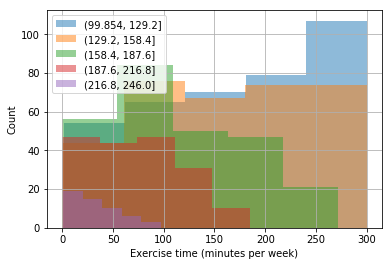

In [87]:
df.groupby(weight_bins).exercise_time.hist(bins = 5, alpha=0.5);
plt.xlabel('Exercise time (minutes per week)')
plt.ylabel('Count')
plt.legend(sorted(weight_list_bins));

There is a negative correlation between exercise time and weight. As exercise goes up, weight is likely to go down. 

In [102]:
df.groupby(age_bins).weight.mean()

age
(17.938, 38.667]    149.225352
(38.667, 59.333]    150.026042
(59.333, 80.0]      161.715385
Name: weight, dtype: float64

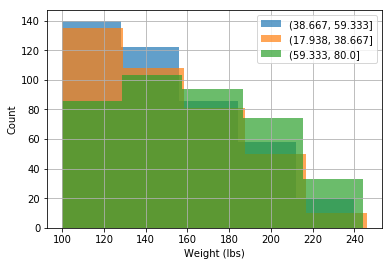

In [107]:
# The last pair of variables to look at is age and weight
df.groupby(age_bins).weight.hist(bins=5, alpha=0.7);
plt.xlabel('Weight (lbs)')
plt.ylabel('Count')
plt.legend(age_bins_list);

There is a decreasing trend here because there are fewer observations of people with higher weights. There doesnt seem to be any correlation between age and weight.

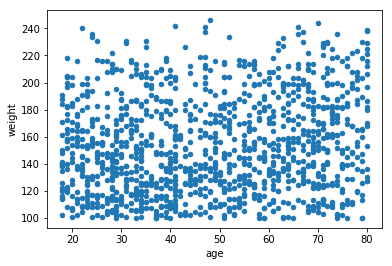

In [110]:
df.plot.scatter('age', 'weight');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All of the variables in this data are continous. 

2.  What are the relationships between the variables?

There is a negative correlation between age and exercise time and a negative correlation between weight and exercise time. That is to say as age or weight goes up you are less likely to exercise for longer periods of time. There is no correlation between age and weight. 

3.  Which relationships are "real", and which spurious?

The spurious relationship here is the one between age and weight. There is a real relationship between age and exercise time and weight and exercise time. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)